[View in Colaboratory](https://colab.research.google.com/github/Mathis1993/Leaf-Classification-CNN/blob/master/Complete_Workflow.ipynb)

# Plant Species Classification using a CNN

<img src="http://drive.google.com/uc?export=view&id=1JyQxgUQk_K4v3LGdeFJlBMABN-WKJt6b">

## Introduction

In the course of learning about AI at [TechLabs](https://tech-labs.de/), we realized a small project to classify plant species using a Convolutional Neural Network (CNN).

In 2012, Neeraj Kumar et al. developed [Leafsnap: A Computer Vision System for Automatic Plant Species Identification](https://neerajkumar.org/base/papers/nk_eccv2012_leafsnap.pdf), a mobile app that identifies all 185 tree species in the Northeastern United States using pictures of their leaves. The classification process is based on a computer vision sytem. This system segments the leaf from its background, extracts curvature features of the leaf's contour and classifies it against a dataset containing examples of all the 185 tree species. With this procedure, a top-1 score of about 72% is achieved (meaning that in 72% of cases, the tree species class the computer vision systems assigns the highest probability to is the correct one). 

Examples of 180 of the 185 different plant species can be examined in the image above.

Using this same dataset, that the authors of the paper make available [here](leafsnap.com/dataset/), we asked ourselves if we could possibly beat the traditional computer vision system's performance by implementing the classification task via a CNN. To maximize our learning success, we did not use a pretrained CNN, but built our own network architecture.

In this post, we want to give a full overview of all the steps we took to train our CNN to classify Northeastern American tree species.

Due to limited computational resources on our private hardware, we used [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb), Google's free cloud service for developing deep Iearning applications on a GPU. We will show the necessary steps for getting ready to work, a detailed tutorial is available on [medium](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d).

## Google Colaboratory

In order to use Google Colaboratory, we worked in a IPython Notebook located in a Google Drive storage. 

**Important**: To use the free GPU, go to "Edit-->Notebook Settings" and select "GPU" as hardware accelerator. 

Once connected, Drive can be mounted to Google Colab so that files stored in Drive will be available using the code snippet below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then, we can navigate to the desired directory...

In [2]:
%cd /content/drive/My Drive/Colab Notebooks/CNN-Model-files

/content/drive/My Drive/Colab Notebooks/CNN-Model-files


... and start working.

## Preprocessing

Consisting of the following steps:
1. Import packages
2. Read data frame with information about pictures
3. Create numeric labels
4. Resize Pictures 
6. Read pictures as RGB arrays
7. Randomize picture order
8. Stack picture input into one array
9. Normalize input features (pictures) and one-hot encode labels
9. Save input features, labels and further info

### 1. Import packages

As a first step, we import the packages necessary for preprocessing the data. 

In [3]:
import os
import PIL
#from PIL import ImageOps
import imageio
import pandas as pd
import numpy as np
import random
import math
import keras

Using TensorFlow backend.


If a package needs to be installed, do:

In [4]:
!pip install imageio

### 2. Read data frame with information about pictures

In the dataset, there is a data frame containing information about the pictures. Relevant for us are the columns:
- path: path to the individual pictures
- species: latin term for each plant
- source: picture taken in lab or field

In [5]:
img_info = pd.read_csv("./leafsnap-dataset-images.txt", sep="\t")
img_info.head()

,file_id,image_path,segmented_path,species,source
0,55497,dataset/images/lab/abies_concolor/ny1157-01-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
1,55498,dataset/images/lab/abies_concolor/ny1157-01-2.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
2,55499,dataset/images/lab/abies_concolor/ny1157-01-3.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
3,55500,dataset/images/lab/abies_concolor/ny1157-01-4.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
4,55501,dataset/images/lab/abies_concolor/ny1157-02-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-02...,Abies concolor,lab


We create a new column only holding the filenames and not the whole path to each picture, so that we can assess the filenames for later resizing of the pictures.

In [0]:
#new column (empty)
img_info["filename"] = None
#index of new column
index_filename = img_info.columns.get_loc("filename")
for i in range(len(img_info)):
    img_info.iloc[i, index_filename] = os.path.basename(str(img_info["image_path"][i]))

### 3. Create numeric labels

Then, we want to have numeric labels instead of the latin term for each plant, so we append another column holding these.
- In the data frame, all images of one species are listed consecutively (first the lab images, then the field images)
- Therefore we just loop over the dataframe and increment the numeric label whenever we encounter a latin term that differs from the previous one

In [6]:
#new column (empty)
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("species")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.tail()

,file_id,image_path,segmented_path,species,source,filename,labels_integer
30861,83817,dataset/images/field/ulmus_rubra/1300222828248...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228282488.jpg,184
30862,83818,dataset/images/field/ulmus_rubra/1300222828261...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228282613.jpg,184
30863,83819,dataset/images/field/ulmus_rubra/1300222828265...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228282655.jpg,184
30864,83820,dataset/images/field/ulmus_rubra/1300222828617...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228286176.jpg,184
30865,83821,dataset/images/field/ulmus_rubra/1300222828044...,dataset/segmented/field/ulmus_rubra/1300222828...,Ulmus rubra,field,13002228280448.jpg,184


### 4. Resize pictures

Next on the list: Resizing the pictures. This is done by reading the filenames from the data frame, generating a cropped version of the desired size for each picture and saving them to an output directory.

In [0]:
def resizeImage(infile, infile_name_only, output_dir="", size=(1024,768)):
  '''
  Resize Images to a requestet size (not considerinng aspect ratio)
  Input:
  - infile: image to be resized (with path)
  - infile_name_only: image to be resized (filename only)
  - output_dir: where resized images should be stored
  - size: output size (tupel of (height, width))
  '''
  
  outfile = os.path.splitext(infile_name_only)[0]
  extension = os.path.splitext(infile)[1]
  
  if infile != outfile:
    if not os.path.isfile(output_dir + "/" + outfile + extension):
      try :
        im = PIL.Image.open(infile)
        #crops to requested size independt from aspec ratio
        im = im.resize(size, PIL.Image.ANTIALIAS) 
        im.save(output_dir + "/" + outfile + extension)
      except IOError:
        print("cannot reduce image for ", infile)

output_dir = "dataset/resized"
size = (256, 256)
filenames_dir = list(img_info["image_path"])
filenames = list(img_info["filename"])
            
for i in range(len(filenames)):
  resizeImage(filenames_dir[i], filenames[i], output_dir=output_dir, size=size)

### 5. Read pictures as RGB arrays

RGB arrays: All resized images are read as rgb arrays in the order they are listed in the data frame. An RGB array is a numeric representation of a picture, assigning three color values (one for each of the three channels: red, green and blue) to each pixel. From a 64x64 picture, we therefore get a 64x64x3 rgb array.


In [0]:
list_vectors = []

for i in range(len(img_info)):
    #path to resized images
    file = "dataset/resized" + "/" + img_info.iloc[i, index_filename]
    #read as rgb array
    img = imageio.imread(file)
    #append image vector to list
    list_vectors.append(img)

### 6. Randomize picture order

As a next step, we want to randomize the order in which the picture data is fed to the CNN to prevent sequence effects, as the data frame comes ordered by species.

In [0]:
#relevant variables
label = img_info["species"]
source = img_info["source"]
label_numeric = img_info["labels_integer"]
list_vectors = list_vectors
filename = img_info["filename"]

#randomization
allinfo = list(zip(label, source, label_numeric, list_vectors, filename)) 
random.shuffle(allinfo) #shuffle
label, source, label_numeric, list_vectors, filename = zip(*allinfo) #decompose again
img_info_rand = pd.DataFrame({"filename":filename, "label":label, "source":source, "label_numeric":label_numeric}) #store picture information in randomized order

### 7. Stack picture input into one array

Now, the picture vectors should be stacked vertically into one array, so that each row represents one picture. This array's shape should then be (30866, 64, 64, 3), as we have 30866 pictures, represented in a 64x64x3 array each. 

In [9]:
X = np.stack((list_vectors))

#transform numeric labels into array
Y = np.asarray(label_numeric)

print(X.shape)

(30866, 256, 256, 3)


### 8. Normalize input features (pictures) and one-hot encode labels

Finally, we normalize the picture data (dividing by 255, as there are 255 conditions possible for each rgb channel) and one-hot encode the numeric labels. One-hot encoding means to go from a representation where each numeric label is just one number (eg 14 for the 14th of 185 classes, so that we have a vector with 30866 entries for our 30866 pictures), to a representation where in a array each column represents a class and each row a picture. Here, picture number n being of class 14 is represented in the nth row, and only the 14th column contains a one, while all others hold zeros.

In [0]:
X = X/255
Y_one_hot = keras.utils.to_categorical(Y, num_classes=185)
print(Y.shape, Y_one_hot.shape)

### 9. Save input features, labels and further info

We can save the input features, labels, and the further information about the pictures (in the randomized order) so that we don't have to repeat all the above steps in the next session.

In [0]:
np.savez("x_images_arrays", X)
np.savez("y_numeric_labels", Y)
img_info_rand.to_csv("img_info_rand_256.csv", index=False)

...loading

In [0]:
x_npz = np.load("x_images_arrays.npz")
X = x_npz['arr_0']

y_npz = np.load("y_numerical_labels.npz")
Y = y_npz['arr_0']

img_info_rand = pd.read_csv("img_info_rand.csv")

## CNN-Model

In order to train a CNN on our dataset, we take the following steps:
1. Import packages
2. Split data in train-/development-/test-set
3. Define the model architecture and compile the model
4. Fit the data
5. Save the model

### 1. Import packages

First, we import the necessary packages.

In [0]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

### 2. Split data in train-/development-/test-set

Next, we split our picture arrays (and the corresponding labels) into three parts:
1. train-set: The data we train the model on (here 80%)
2. development-set (dev-set): The data we use to evaluate the model's generalization performance (to new, unseen data) during training (here 10%)
3. test-set: The data we want to predict using our trained model (here 10%)
  - For further evaluation of results, we isolate labels (latin terms), numeric labels, filenames and source (lab/field) for the test-set

In [9]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y[:index_train]
Y_val = Y[index_train:index_val]
Y_test = Y[index_val:]

#for later predictions on test set
labels_numeric_test = img_info_rand.loc[index_val:len(X), "label_numerical"]
labels_test = img_info_rand.loc[index_val:len(X), "label"]
filenames_test = img_info_rand.loc[index_val:len(X), "filename"]
source_test = img_info_rand.loc[index_val:len(X), "source"]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(24692, 64, 64, 3) (3087, 64, 64, 3) (3087, 64, 64, 3) (24692, 185) (3087, 185) (3087, 185)


### 3. Define the model architecture and compile the model

- **Architecture**

The model takes as input pictures of the size (m, 64, 64, 3), so 64x64 colored images (3 rgb channels). 

In a first convolutional layer, 32 5x5 filters are applied with a stride of 1 (so each filter sliding over the picture in steps of 1 pixel) and no padding. Therefore, the output of this convolutional layer will be (m, 60, 60, 32). 

This is fed to a max pooling layer, in which a (2,2) window selecting each maximum slides over the input with a stride of 2, collapsing the input to a output of (m, 30, 30 ,32). 

The next convolutional layer consists of 64 5x5 filters, again with a stride of 1. This generates a output of (m, 26, 26, 64),

which through the next pooling layer (specifications as in the first one) is collapsed to a size of (m, 13, 13, 64). 

The output of this pooling layer is then flattened into a matrix of (10816, m) (13x13x64 = 10816) and 

fed to a fully connected layer with 1000 nodes, which in turn outputs (1000, m)

to the final softmax layer with 185 nodes (185 classes), giving (185, m) as the final output. 

---

- **Activation functions**

A Rectified Linear Unit Activation function is used throughout the network (except for the final softmax layer).


---


- **Parameters**

Learnable parameters are the values of the filter matrices as well as the weights in the fully connected layers.


---


- **Normalization**

Batch Normalization (the output of a previous activation layer is normalized by subtracting the batch mean and dividing by the batch standard deviation) was applied to reduce activations shifting around in a high range, thus making the model more robust and speeding up learning. 


---


- **Regularization**

After the final max pooling layer and the fully connected layer feeding into the final softmax layer, dropout was implemented to reduce overfitting (in dropout, activations are randomly set to zero with a certain possibility (here 0.7) to prevent the model from only relying on certain high activations resulting from replicating noise in the training data instead of finding a meaningful input to output mapping.


---


- **Optimizer**

The model was trained with an Adam optimizer as gradient descent optimization algorithm, which combines moving averages of past weights and squared moving average of past weights (moving average of past weights: At each time step, the average over the last eg 10 weights is calculated and incorporated in the weight updating, so that we not only consider the current timestep, but also timesteps from the past to prevent drastic changes in direction (leading to valleys or local minima) when searching for the minimum in gradient descent, as go into the direction most oft he gradients push as (along the current gradient „flow“)). Hyperparameters controlling the moving averages are beta1 and beta2. Learning rate was set to 0.0001 with a decay of e-8 (to prevent overshooting the global minimum). As loss function, categroical cross entropy cost was used.

In [0]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) #(64, 64, 3)
num_classes = 185

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 64)        0         
__________

### 4. Fit the data (and save the best model)

In [11]:
# autosave best Model
best_model_file = "leafnet.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
results = model1.fit(X_train, Y_train, epochs=400, batch_size=512, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...
Train on 24692 samples, validate on 3087 samples
Epoch 1/400
24692/24692 [==============================] - 13s 524us/step - loss: 6.9255 - acc: 0.0180 - val_loss: 4.1561 - val_acc: 0.1318

Epoch 00001: val_loss improved from inf to 4.15608, saving model to leafnet_batch_512.h5
Epoch 2/400
24692/24692 [==============================] - 11s 450us/step - loss: 5.6699 - acc: 0.0577 - val_loss: 3.4366 - val_acc: 0.2310

Epoch 00002: val_loss improved from 4.15608 to 3.43664, saving model to leafnet_batch_512.h5
Epoch 3/400
24692/24692 [==============================] - 11s 452us/step - loss: 4.9649 - acc: 0.0958 - val_loss: 2.9717 - val_acc: 0.3094

Epoch 00003: val_loss improved from 3.43664 to 2.97165, saving model to leafnet_batch_512.h5
Epoch 4/400
24692/24692 [==============================] - 11s 452us/step - loss: 4.4661 - acc: 0.1309 - val_loss: 2.6748 - val_acc: 0.3732

Epoch 00004: val_loss improved from 2.97165 to 2.67475, saving model to leafnet_batch_512.h5
E

### Evaluate the model

In [13]:
model.evaluate(X_test, Y_test)

3087/3087 [==============================] - 1s 404us/step


[0.38075798154263424, 0.8875931325104]

## Examination/visualization of results

Results are examined/visualized by the following steps:

1. Import packages
2. Plot train/dev accuracy and loss

### 1. Import packages

In [0]:
from matplotlib import pyplot as plt

### 2. Plot train/dev accuracy and loss

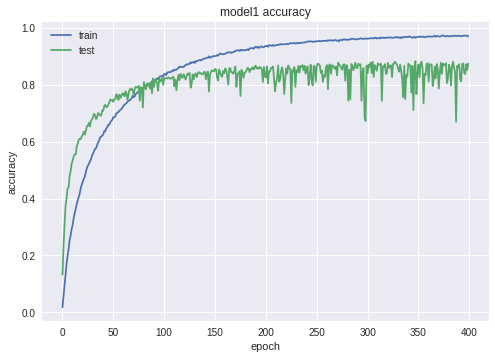

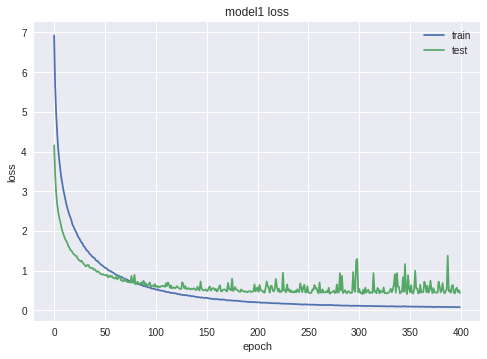

In [16]:
# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Prediction dataset and confusion matrix

Number of examples per class

- Histogram of number of examples per class
- regression: errors on number of examples (and their correlation)

Fehleranzahl nach field/lab?

top Fehler-Klassen / top richtige Klassen --> kleine Blätter bei 64x64

Heatmaps

Zukunft: Mehr computational power, höhere Auflösung (kleine Blätter)

Terminate the kernel and free memory resources

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)